In [37]:
import re
import json

def get_confidence(input_str, review_id):
    # Only the part of the string after "confidence for outlier"
    start_index = input_str.find("confidence for outlier:")
    relevant_part = input_str[start_index:]

    pattern = f"review{review_id}"
    regex = r"\{" + pattern + r"\}\((.*?)\)"

    # "Confidence for outlier part", note index is 0 not 1.
    line = relevant_part.split("\n")[0]

    match = re.search(regex, line)
    if match:
        confidence = match.group(1)
        return confidence


def count_data(file_path, medium_type):
    """_summary_

    Args:
        file_path (str): json file path
        model_name (str): gpt-3.5-turbo or llamas
        medium_type (int): True if MEDIUM as an outlier.

    Returns:
        _type_: _description_
    """
    detected_outliers_count = 0
    total_reviews_count = 0
    total_outliers_count = 0
    correct_outlier_predictions = 0 # True Positives
    ground_truths = [] # 1 if outlier, 0 if not outlier
    ground_truth_probs = []
    
    # Outlier Types
    outlier_types = ["HIGH"] + ["MEDIUM"] if medium_type else ["HIGH"]
    outlier_confidence_scores_type = [0.9, 0.6, 0.3]

    with open(file_path, "r") as file:
        data = json.load(file)

        for entry in data:
            # print(entry["ID"])
            # Check if the entry is a valid JSON object with the required fields
            if all(key in entry for key in ["output", "ground_truth"]) and isinstance(
                entry["output"], str
            ):
                output = entry["output"]
                ground_truth = entry["ground_truth"]
                total_reviews_count += len(ground_truth)
                total_outliers_count += sum(1 for gt in ground_truth if -1 in gt.values())

                # 1 if outlier, 0 if not outlier (outliers as positives)
                ground_truths += [0 if list(gt.values())[0] == 1 else 1 for gt in ground_truth]

                for i in range(1, len(ground_truth)+1):
                    # confidence = get_confidence(output, i)
                    # if confidence == "HIGH":
                    #     outlier_confidence_score = outlier_confidence_scores_type[0]
                    # elif confidence == "MEDIUM":
                    #     outlier_confidence_score = outlier_confidence_scores_type[1]
                    # else:
                    #     outlier_confidence_score = outlier_confidence_scores_type[2]
                    # ground_truth_probs.append(outlier_confidence_score)

                    # # Detected as outlier
                    # if f"review{i}" in output.split("\n")[0] and confidence in outlier_types:
                    #     detected_outliers_count += 1

                    #     # If the prediction is correct, add ONE to the correct_outlier_predictions counter
                    #     if list(ground_truth[i - 1].values())[0] == -1:
                    #         correct_outlier_predictions += 1

                    # Test: All detected as ground truth
                    if list(ground_truth[i - 1].values())[0] == -1:
                        detected_outliers_count += 1
                        correct_outlier_predictions += 1
                        ground_truth_probs.append(1)
                    else:
                        ground_truth_probs.append(0)


    return (
        total_reviews_count,
        total_outliers_count,
        detected_outliers_count,
        correct_outlier_predictions,
        ground_truths,
        ground_truth_probs
    )

In [2]:
str(int(True))

'1'

TP: 2671
FP: 0
TN: 15711
FN: 0

pr_thresholds: 0.0000      precisions: 0.1453      recalls: 1.0000    
pr_thresholds: 1.0000      precisions: 1.0000      recalls: 1.0000    
average_precision_score: 1.0000

thresholds: inf         fpr: 0.0000      tpr: 0.0000    
thresholds: 1.0000      fpr: 0.0000      tpr: 1.0000    
thresholds: 0.0000      fpr: 1.0000      tpr: 1.0000    
roc_auc_score: 1.0000



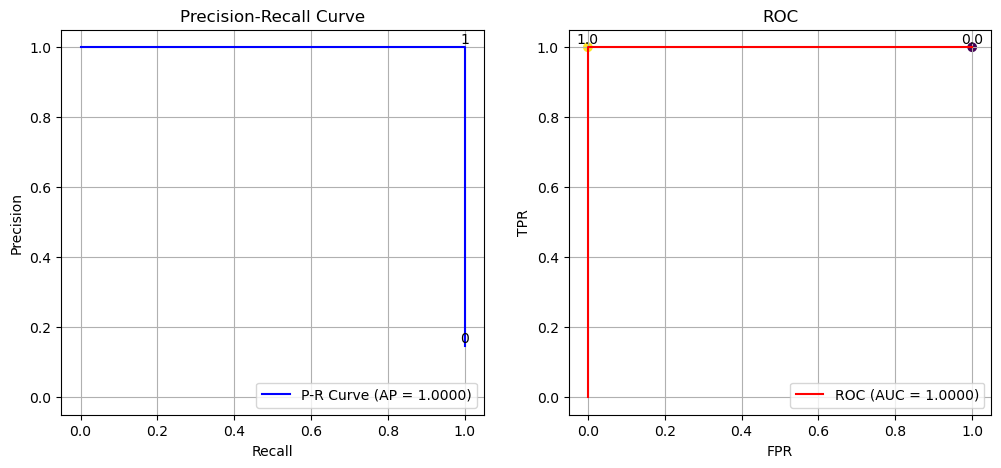

In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from matplotlib import pyplot as plt

model_name = 'gpt'

file_paths = [f'./output_{model_name}.json', f'./output_{model_name}2.json', f'./output_{model_name}3.json']

total_reviews_count = 0
total_outliers_count = 0
detected_outliers_count = 0
correct_outlier_predictions = 0
ground_truths = []
ground_truth_probs = []

for file_path in file_paths:
    total_reviews, total_outliers, detected_outliers, correct_predictions, truths, probs = count_data(file_path, 0)
    total_reviews_count += total_reviews
    total_outliers_count += total_outliers
    detected_outliers_count += detected_outliers
    correct_outlier_predictions += correct_predictions
    ground_truths += truths
    ground_truth_probs += probs

true_positives = correct_outlier_predictions
false_positives = detected_outliers_count - correct_outlier_predictions
false_negatives = total_outliers_count - correct_outlier_predictions
true_negatives = total_reviews_count - total_outliers_count - false_positives


print(f'TP: {true_positives}')
print(f'FP: {false_positives}')
print(f'TN: {true_negatives}')
print(f'FN: {false_negatives}')
print()

# Precision-Recall curve & AP score
precisions, recalls, pr_thresholds = precision_recall_curve(ground_truths, ground_truth_probs)
for i, value in enumerate(pr_thresholds):
    print(f"pr_thresholds: {value:<10.4f}  precisions: {precisions[i]:<10.4f}  recalls: {recalls[i]:<10.4f}")
ap_score = average_precision_score(ground_truths, ground_truth_probs)
print(f"average_precision_score: {ap_score:.4f}")
print()

# ROC & AUC
fpr, tpr, roc_thresholds = roc_curve(ground_truths, ground_truth_probs)
for i, value in enumerate(roc_thresholds):
    print(f"thresholds: {value:<10.4f}  fpr: {fpr[i]:<10.4f}  tpr: {tpr[i]:<10.4f}")
# print(f"auc: {auc(fpr, tpr)}") # same number as roc_auc_score
auc_score = roc_auc_score(ground_truths, ground_truth_probs)
print(f"roc_auc_score: {auc_score:.4f}")
print()


# plotting
plt.figure(figsize=(12, 5))

# Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, color='blue', label=f'P-R Curve (AP = {ap_score:.4f})')
# plt.scatter(recalls, precisions, c=pr_thresholds)
# plt.colorbar(label='P-R Threshold')
# annotate thresholds text above the points
for i, value in enumerate(pr_thresholds):
    if value <= 1:
        plt.annotate(str(value), (recalls[i], precisions[i]), textcoords="offset points", xytext=(0,3), ha='center')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")

# ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='red', label=f'ROC (AUC = {auc_score:.4f})')
plt.scatter(fpr, tpr, c=roc_thresholds)
# plt.colorbar(label='Threshold')

# 在每个点上方添加文本标注
for i, value in enumerate(roc_thresholds):
    if value <= 1:
        plt.annotate(str(value), (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,3), ha='center')

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")

# plt.tight_layout()
plt.show()

# Draft

In [8]:
import json

with open('output_gpt.json', "r") as file:
        data = json.load(file)

        print(data[0]["ID"])
        # Check if the entry is a valid JSON object with the required fields
        if all(key in data[0] for key in ["output", "ground_truth"]) and isinstance(
            data[0]["output"], str
        ):
            output = data[0]["output"]
            ground_truth = data[0]["ground_truth"]
            # total_reviews_count += len(ground_truth)
            # total_outliers_count += sum(1 for gt in ground_truth if -1 in gt.values())
            
            # ground_truths += [1 if list(gt.values())[0] == 1 else 0 for gt in ground_truth]

print(f'\noutput:\n{output}')
print(f'\nground_truth:\n{ground_truth}')
print(f'\nground_truths: {[0 if list(gt.values())[0] == 1 else 1 for gt in ground_truth]}')

132_1

output:
A: Outlier reviews ID: review2
confidence for outlier: {review2}(MEDIUM)
reasons:
- review2: This review stands out from the others because it provides a positive overall assessment of the sushi and value, despite mentioning loud and chaotic music and not being a great place for a first date. The positive rating given in this context is inconsistent with the typical expectations for a 4-star review, making it an outlier.

ground_truth:
[{'1': 1}, {'2': 1}, {'3': 1}]

ground_truths: [0, 0, 0]


In [19]:
medium_type = False
["HIGH"] + ["MEDIUM"] if medium_type else ["HIGH"]

['HIGH']